In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

import sys

sys.path.append('../src')

import warnings
warnings.filterwarnings("ignore")

### Test focal region similarity

In [2]:
from Classes.focal_regions import FocalRegion

In [3]:
region = np.array([[1, 0], [0, 1]])
fra = FocalRegion(region)
fra.debug = True

history = np.array([[1, 0], [0, 1]])
print('History:\n', history)
print('-'*60)
scores = fra.get_similarity_scores(history)
print('Scores:\n', scores)
print('-'*60)

History:
 [[1 0]
 [0 1]]
------------------------------------------------------------
Cicle from column 0:
[[1 0]
 [0 1]]
Similarity score: 1.0
Cicle from column 1:
[[0 1]
 [1 0]]
Similarity score: 0.0
Scores:
 [np.float64(1.0), np.float64(0.0)]
------------------------------------------------------------


<Axes: >

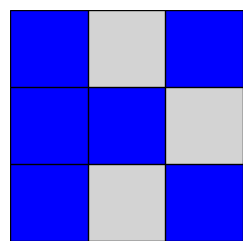

In [4]:
FocalRegion.draw_region(np.array([[1, 0, 1], [1, 1, 0], [1, 0, 1]]))

### Test FRA agents

In [4]:
from Classes.bar import Bar
from Utils.interaction import Episode
from Classes.experimental import FocalRegionAgent, SetFocalRegions

In [5]:
free_parameters = {
    'inverse_temperature': 10,
    'len_history': 2,
    'max_regions': 5
}
fixed_parameters = {
    'num_agents': 7,
    'threshold': 0.7,
}
n = 1

In [6]:
# Create the environment
bar = Bar(
    num_agents=fixed_parameters['num_agents'],
    threshold=fixed_parameters['threshold']
)
# Create the agents
agents = [FocalRegionAgent(free_parameters, fixed_parameters, n) for n in range(fixed_parameters['num_agents'])]
# Create the episode
episode = Episode(
    model='FRA',
    agents=agents,
    environment=bar,
    num_rounds=20
)

In [ ]:
print('Focal regions:')
print(episode.agents[0].sfr)

In [8]:
# episode.agents[0].debug = True
# episode.agents[1].debug = True
episode.run()

In [ ]:
bar.render()

# Test parameter fit

In [10]:
from Classes.parameter_recovery import ParameterFit

In [11]:
# Create paths for data and results
data_folder = Path('..', 'data', 'human')
folder_2P = Path('..', 'reports', 'MLE')
folder_2P.mkdir(parents=True, exist_ok=True)

file_name = f'best_fit_2P_3.json'
best_fit_file_2P = Path(folder_2P, file_name)

In [ ]:
#Load 2P data

file_name = '2-player-UR.csv'
file = data_folder / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data.head(2)

In [ ]:
# check_out_these = ['Attendance-M2', 'MFP-M2', 'Payoff-M2']
my_models = [FocalRegionAgent]

ParameterFit.run(
    data=data,
    model_list=my_models,
    best_fit_path=best_fit_file_2P,
    new_file=False
)